# Machine Learning Pipeline for BMI Prediction

This notebook demonstrates a complete pipeline for predicting BMI from metagenomic data. The pipeline includes data preparation, baseline modeling, feature selection, hyperparameter tuning, bootstrap evaluation, and final model retraining for deployment.

In [19]:
import pandas as pd
import numpy as np
import sys
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone

from numpy.random import choice

# Append parent directory to path to load our custom functions
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(".."))
from src.functions import MLWorkflow

## Data Loading and Preparation

In this section, we load the development and evaluation datasets, and separate the features from the target variable.

In [20]:
dataFolder = "../data/"
devPath = os.path.join(dataFolder, "development_final_data.csv")
evalPath = os.path.join(dataFolder, "evaluation_final_data.csv")

print("Loading development (training) data now...")
devData = pd.read_csv(devPath)
print("Loading evaluation data now...")
evalData = pd.read_csv(evalPath)

print("Preparing data for modeling...")
# Use the last column as target
targetCol = devData.columns[-1]
print("Target variable is: " + str(targetCol))

# Extract features and target for development data
X_dev = devData.drop(columns=[targetCol]).values
y_dev = devData[targetCol].values

# Extract features and target for evaluation data
X_eval = evalData.drop(columns=[targetCol]).values
y_eval = evalData[targetCol].values

print("Dev set shape: " + str(X_dev.shape))
print("Eval set shape: " + str(X_eval.shape))


Loading development (training) data now...
Loading evaluation data now...
Preparing data for modeling...
Target variable is: Sex_Male
Dev set shape: (489, 136)
Eval set shape: (211, 136)


## Baseline Models (No Feature Selection, No Tuning)

Here we create and train baseline models (ElasticNet, SVR, and Bayesian Ridge) using all features without any preprocessing or tuning. These will serve as our performance benchmarks.

In [21]:
print("\n--- Generating Baseline Models ---")
baseModels = {}  # dictionary to store baseline models
# Create a workflow instance to access preconfigured models
myWorkflow = MLWorkflow()

# Create fresh instances for baseline models
algoDict = {}
algoDict["elastic_net"] = myWorkflow.models["elastic_net"].__class__()
algoDict["svr"] = myWorkflow.models["svr"].__class__()
algoDict["bayesian_ridge"] = myWorkflow.models["bayesian_ridge"].__class__()

modelFolder = "../models"
os.makedirs(modelFolder, exist_ok=True)

# Train each baseline model
for nm in algoDict:
    print("\nTraining baseline model for " + nm + " ...")
    mdl = algoDict[nm]
    mdl.fit(X_dev, y_dev)
    modPath = os.path.join(modelFolder, nm + "_baseline.joblib")
    joblib.dump(mdl, modPath)
    print("Saved baseline model for " + nm + " to " + modPath)
    baseModels[nm] = mdl



--- Generating Baseline Models ---

Training baseline model for elastic_net ...
Saved baseline model for elastic_net to ../models/elastic_net_baseline.joblib

Training baseline model for svr ...
Saved baseline model for svr to ../models/svr_baseline.joblib

Training baseline model for bayesian_ridge ...
Saved baseline model for bayesian_ridge to ../models/bayesian_ridge_baseline.joblib


## Evaluate Baseline Models

We evaluate the baseline models on the evaluation set using RMSE, MAE, and R² metrics.

In [22]:
print("\n--- Evaluating Baseline Models ---")
baseResList = []  # list to store results
for nm in baseModels:
    print("Evaluating " + nm + " model...")
    modl = baseModels[nm]
    yPred = modl.predict(X_eval)
    rmse_val = np.sqrt(mean_squared_error(y_eval, yPred))
    mae_val = mean_absolute_error(y_eval, yPred)
    r2_val = r2_score(y_eval, yPred)
    print(f"{nm}: RMSE={rmse_val:.4f}, MAE={mae_val:.4f}, R²={r2_val:.4f}")
    baseResList.append({
        "Model": nm,
        "RMSE": rmse_val,
        "MAE": mae_val,
        "R²": r2_val,
        "Approach": "Baseline"
    })
baseDF = pd.DataFrame(baseResList)
print("\n--- Baseline Model Comparison ---")
print(baseDF.to_string(index=False))



--- Evaluating Baseline Models ---
Evaluating elastic_net model...
elastic_net: RMSE=0.4696, MAE=0.4549, R²=-0.0021
Evaluating svr model...
svr: RMSE=0.4668, MAE=0.3586, R²=0.0098
Evaluating bayesian_ridge model...
bayesian_ridge: RMSE=0.4588, MAE=0.4161, R²=0.0436

--- Baseline Model Comparison ---
         Model     RMSE      MAE        R² Approach
   elastic_net 0.469607 0.454935 -0.002065 Baseline
           svr 0.466817 0.358598  0.009806 Baseline
bayesian_ridge 0.458778 0.416059  0.043616 Baseline


## Feature Selection Stage

We now perform feature selection using the `select_features` method from our workflow. This reduces the dimensionality and helps in selecting a stable subset of features.

In [23]:
print("\n--- Feature Selection on Development Set ---")
selFeatMask, numFeat, fs_rmse = myWorkflow.select_features(X_dev, y_dev)
print("Selected " + str(numFeat) + " features with CV RMSE: " + str(round(fs_rmse, 4)))
print("Feature mask (first 20): " + str(selFeatMask[:20]))



--- Feature Selection on Development Set ---
Trying 1 features for elastic_net gives score 0.4884991659189953
Trying 1 features for svr gives score 0.5214253394892394
Trying 1 features for bayesian_ridge gives score 0.4757594074060162
Trying 2 features for elastic_net gives score 0.4884991659189953
Trying 2 features for svr gives score 0.5169111651484719
Trying 2 features for bayesian_ridge gives score 0.4737523595333816
Trying 3 features for elastic_net gives score 0.4884991659189953
Trying 3 features for svr gives score 0.503300163124298
Trying 3 features for bayesian_ridge gives score 0.4675900610911265
Trying 4 features for elastic_net gives score 0.4884991659189953
Trying 4 features for svr gives score 0.4853575116506349
Trying 4 features for bayesian_ridge gives score 0.46357384468261004
Trying 5 features for elastic_net gives score 0.4884991659189953
Trying 5 features for svr gives score 0.4818154868323627
Trying 5 features for bayesian_ridge gives score 0.46034072244539564
Try

## Train Models on Selected Features (No Tuning)

Using the selected features, we retrain the models without tuning. This step helps us evaluate the impact of feature selection alone.

In [24]:
print("\n--- Training Models on Selected Features ---")
fsModels = {}
for nm in algoDict:
    print("Cloning model for " + nm + " and training on selected features...")
    freshModel = clone(algoDict[nm])  # get a new model instance
    X_dev_fs = X_dev[:, selFeatMask]
    freshModel.fit(X_dev_fs, y_dev)
    fsModPath = os.path.join(modelFolder, nm + "_fs.joblib")
    joblib.dump(freshModel, fsModPath)
    print("Saved feature-selected model for " + nm + " to " + fsModPath)
    fsModels[nm] = freshModel



--- Training Models on Selected Features ---
Cloning model for elastic_net and training on selected features...
Saved feature-selected model for elastic_net to ../models/elastic_net_fs.joblib
Cloning model for svr and training on selected features...
Saved feature-selected model for svr to ../models/svr_fs.joblib
Cloning model for bayesian_ridge and training on selected features...
Saved feature-selected model for bayesian_ridge to ../models/bayesian_ridge_fs.joblib


## Evaluate Feature-Selected Models

Next, we evaluate the models trained on the selected features using the evaluation set.

In [25]:
print("\n--- Evaluating Feature-Selected Models ---")
fsResList = []
for nm in fsModels:
    print("Evaluating feature-selected model for " + nm + " ...")
    mdl_fs = fsModels[nm]
    X_eval_fs = X_eval[:, selFeatMask]
    yPred_fs = mdl_fs.predict(X_eval_fs)
    rmse_fs = np.sqrt(mean_squared_error(y_eval, yPred_fs))
    mae_fs = mean_absolute_error(y_eval, yPred_fs)
    r2_fs = r2_score(y_eval, yPred_fs)
    print(f"{nm}: RMSE={rmse_fs:.4f}, MAE={mae_fs:.4f}, R²={r2_fs:.4f}")
    fsResList.append({
        "Model": nm,
        "RMSE": rmse_fs,
        "MAE": mae_fs,
        "R²": r2_fs,
        "Approach": "Feature Selected"
    })
fsDF = pd.DataFrame(fsResList)
print("\n--- Feature-Selected Model Comparison ---")
print(fsDF.to_string(index=False))



--- Evaluating Feature-Selected Models ---
Evaluating feature-selected model for elastic_net ...
elastic_net: RMSE=0.4724, MAE=0.4593, R²=-0.0139
Evaluating feature-selected model for svr ...
svr: RMSE=0.4689, MAE=0.3645, R²=0.0011
Evaluating feature-selected model for bayesian_ridge ...
bayesian_ridge: RMSE=0.4489, MAE=0.4101, R²=0.0844

--- Feature-Selected Model Comparison ---
         Model     RMSE      MAE        R²         Approach
   elastic_net 0.472382 0.459318 -0.013945 Feature Selected
           svr 0.468869 0.364452  0.001081 Feature Selected
bayesian_ridge 0.448889 0.410129  0.084400 Feature Selected


## Compare Baseline vs. Feature-Selected Models

We now compare the performance of the baseline models with those trained on the selected features.

In [26]:
compDF = pd.concat([baseDF, fsDF])
print("\n--- Comparison of Baseline vs. Feature-Selected Models ---")
print(compDF.to_string(index=False))



--- Comparison of Baseline vs. Feature-Selected Models ---
         Model     RMSE      MAE        R²         Approach
   elastic_net 0.469607 0.454935 -0.002065         Baseline
           svr 0.466817 0.358598  0.009806         Baseline
bayesian_ridge 0.458778 0.416059  0.043616         Baseline
   elastic_net 0.472382 0.459318 -0.013945 Feature Selected
           svr 0.468869 0.364452  0.001081 Feature Selected
bayesian_ridge 0.448889 0.410129  0.084400 Feature Selected


## FS + Tuning Stage (Hyperparameter Tuning)

In this section, we perform hyperparameter tuning on the models using the selected features. We use GridSearchCV with a KFold cross-validation scheme.

In [27]:
print("\n--- Hyperparameter Tuning on Feature-Selected Models ---")
paramGrids = {}
paramGrids["elastic_net"] = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}
paramGrids["svr"] = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.2],
    "kernel": ["linear", "rbf"],
}
paramGrids["bayesian_ridge"] = {
    "alpha_1": [1e-7, 1e-6, 1e-5],
    "alpha_2": [1e-7, 1e-6, 1e-5],
    "lambda_1": [1e-7, 1e-6, 1e-5],
    "lambda_2": [1e-7, 1e-6, 1e-5],
}

tunedModels = {}
tuningResList = []
X_dev_fs = X_dev[:, selFeatMask]
kfoldObj = KFold(n_splits=myWorkflow.k_folds, shuffle=True, random_state=42)

for nm in algoDict:
    print("\nTuning model " + nm + " on feature-selected data...")
    tempModel = clone(algoDict[nm])
    gridSearch = GridSearchCV(
        tempModel,
        paramGrids[nm],
        cv=kfoldObj,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )
    gridSearch.fit(X_dev_fs, y_dev)
    bestMod = gridSearch.best_estimator_
    bestScr = -gridSearch.best_score_
    bestPrms = gridSearch.best_params_
    print("Best " + nm + " model: RMSE=" + str(round(bestScr, 4)) + ", Params=" + str(bestPrms))
    tunedModels[nm] = bestMod
    tuningResList.append({
        "Model": nm,
        "RMSE": bestScr,
        "Best Params": bestPrms,
        "Approach": "FS+Tuning"
    })

tuningDF = pd.DataFrame(tuningResList)
print("\n--- Tuning Results ---")
print(tuningDF.to_string(index=False))



--- Hyperparameter Tuning on Feature-Selected Models ---

Tuning model elastic_net on feature-selected data...
Best elastic_net model: RMSE=0.4501, Params={'alpha': 0.0001, 'l1_ratio': 0.1}

Tuning model svr on feature-selected data...
Best svr model: RMSE=0.4331, Params={'C': 1, 'epsilon': 0.2, 'kernel': 'rbf'}

Tuning model bayesian_ridge on feature-selected data...
Best bayesian_ridge model: RMSE=0.4507, Params={'alpha_1': 1e-05, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 1e-05}

--- Tuning Results ---
         Model     RMSE                                                                Best Params  Approach
   elastic_net 0.450065                                         {'alpha': 0.0001, 'l1_ratio': 0.1} FS+Tuning
           svr 0.433061                                  {'C': 1, 'epsilon': 0.2, 'kernel': 'rbf'} FS+Tuning
bayesian_ridge 0.450745 {'alpha_1': 1e-05, 'alpha_2': 1e-07, 'lambda_1': 1e-07, 'lambda_2': 1e-05} FS+Tuning


## Save Tuned Models to Final Models Folder

The best tuned model for each regressor is saved in the `final_models` folder for later deployment.

In [28]:
finalModelsFolder = "../final_models"
os.makedirs(finalModelsFolder, exist_ok=True)
for nm in tunedModels:
    finalModPath = os.path.join(finalModelsFolder, nm + "_final_model.joblib")
    joblib.dump(tunedModels[nm], finalModPath)
    print("Saved final tuned model for " + nm + " to " + finalModPath)


Saved final tuned model for elastic_net to ../final_models/elastic_net_final_model.joblib
Saved final tuned model for svr to ../final_models/svr_final_model.joblib
Saved final tuned model for bayesian_ridge to ../final_models/bayesian_ridge_final_model.joblib


## Evaluate Tuned Models on Evaluation Set

We evaluate the tuned models (FS+Tuning) on the evaluation set to compare their performance.

In [29]:
print("\n--- Evaluating Tuned Models on Evaluation Set ---")
tunedResList = []
for nm in tunedModels:
    print("Evaluating tuned model for " + nm + " ...")
    mod_tuned = tunedModels[nm]
    X_eval_fs = X_eval[:, selFeatMask]
    yPred_tuned = mod_tuned.predict(X_eval_fs)
    rmse_tuned = np.sqrt(mean_squared_error(y_eval, yPred_tuned))
    mae_tuned = mean_absolute_error(y_eval, yPred_tuned)
    r2_tuned = r2_score(y_eval, yPred_tuned)
    print(f"{nm}: RMSE={rmse_tuned:.4f}, MAE={mae_tuned:.4f}, R²={r2_tuned:.4f}")
    tunedResList.append({
        "Model": nm,
        "RMSE": rmse_tuned,
        "MAE": mae_tuned,
        "R²": r2_tuned,
        "Approach": "FS+Tuning"
    })
tunedDF = pd.DataFrame(tunedResList)
print("\n--- Tuned Model Comparison ---")
print(tunedDF.to_string(index=False))



--- Evaluating Tuned Models on Evaluation Set ---
Evaluating tuned model for elastic_net ...
elastic_net: RMSE=0.4510, MAE=0.4061, R²=0.0756
Evaluating tuned model for svr ...
svr: RMSE=0.4562, MAE=0.3902, R²=0.0543
Evaluating tuned model for bayesian_ridge ...
bayesian_ridge: RMSE=0.4489, MAE=0.4101, R²=0.0844

--- Tuned Model Comparison ---
         Model     RMSE      MAE       R²  Approach
   elastic_net 0.451034 0.406127 0.075628 FS+Tuning
           svr 0.456204 0.390226 0.054317 FS+Tuning
bayesian_ridge 0.448889 0.410127 0.084399 FS+Tuning


## Final Comparison of All Approaches

We now combine the results from the baseline, feature-selected, and FS+tuning stages to compare overall performance.

In [30]:
finalCompDF = pd.concat([baseDF, fsDF, tunedDF])
print("\n--- Final Comparison of All Approaches ---")
print(finalCompDF.to_string(index=False))



--- Final Comparison of All Approaches ---
         Model     RMSE      MAE        R²         Approach
   elastic_net 0.469607 0.454935 -0.002065         Baseline
           svr 0.466817 0.358598  0.009806         Baseline
bayesian_ridge 0.458778 0.416059  0.043616         Baseline
   elastic_net 0.472382 0.459318 -0.013945 Feature Selected
           svr 0.468869 0.364452  0.001081 Feature Selected
bayesian_ridge 0.448889 0.410129  0.084400 Feature Selected
   elastic_net 0.451034 0.406127  0.075628        FS+Tuning
           svr 0.456204 0.390226  0.054317        FS+Tuning
bayesian_ridge 0.448889 0.410127  0.084399        FS+Tuning


## Bootstrap Evaluation & Boxplots

We perform bootstrap evaluation to generate distributions for RMSE, MAE, and R² metrics, and then create boxplots to visually compare the performance of models across different stages.

Bootstrap iteration 1 completed with RMSE = 0.4669507518173379
Bootstrap iteration 2 completed with RMSE = 0.4671293747226226
Bootstrap iteration 3 completed with RMSE = 0.4764468491212952
Bootstrap iteration 4 completed with RMSE = 0.47612275575932395
Bootstrap iteration 5 completed with RMSE = 0.47965474141655484
Bootstrap iteration 6 completed with RMSE = 0.4662763700685866
Bootstrap iteration 7 completed with RMSE = 0.46081728264855903
Bootstrap iteration 8 completed with RMSE = 0.47171046037360553
Bootstrap iteration 9 completed with RMSE = 0.4682666655922318
Bootstrap iteration 10 completed with RMSE = 0.48595883337665297
Bootstrap iteration 11 completed with RMSE = 0.47891542549782257
Bootstrap iteration 12 completed with RMSE = 0.4809725020252788
Bootstrap iteration 13 completed with RMSE = 0.47256418974075487
Bootstrap iteration 14 completed with RMSE = 0.4715908272760834
Bootstrap iteration 15 completed with RMSE = 0.46210799137112535
Bootstrap iteration 16 completed with RMS

/var/folders/9y/ycvl1mqx3lb9rqx0kt8lhpp00000gn/T/ipykernel_11661/3359332466.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=groups)


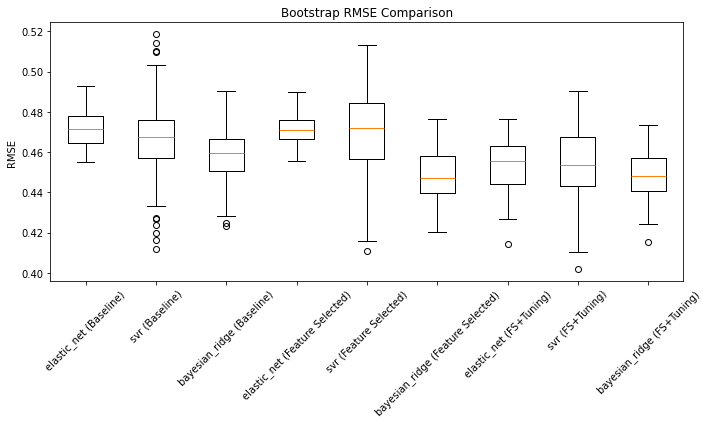

/var/folders/9y/ycvl1mqx3lb9rqx0kt8lhpp00000gn/T/ipykernel_11661/3359332466.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=groups)


Boxplot for RMSE displayed.


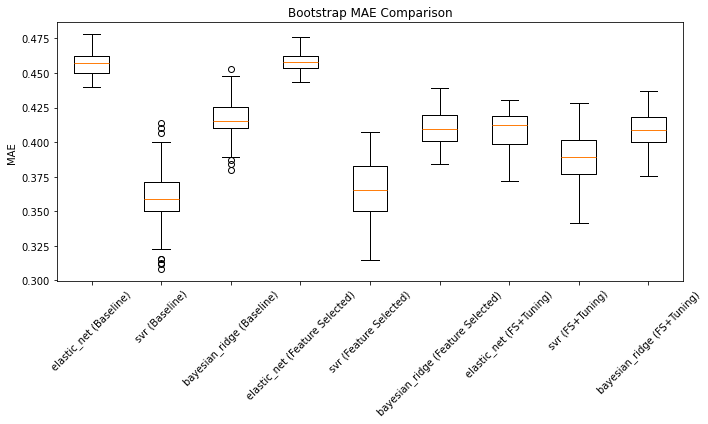

Boxplot for MAE displayed.


/var/folders/9y/ycvl1mqx3lb9rqx0kt8lhpp00000gn/T/ipykernel_11661/3359332466.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=groups)


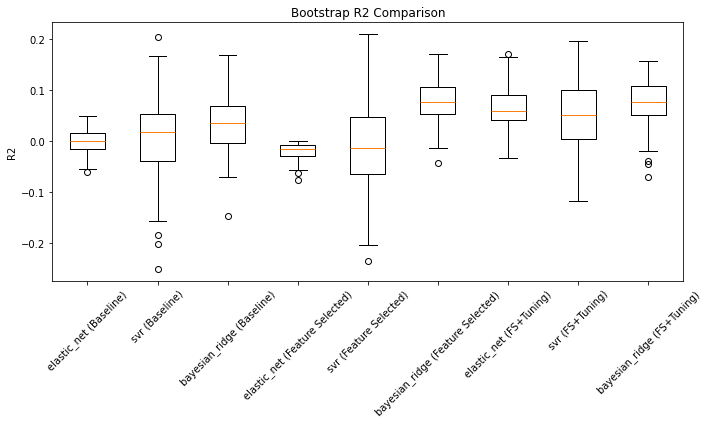

Boxplot for R2 displayed.


In [31]:
def bootstrap_evaluation(mod, X_data, y_data, n_bootstraps=100, feature_mask=None):
    rmse_list = []
    mae_list = []
    r2_list = []
    tot_samples = len(y_data)
    for i in range(n_bootstraps):
        rand_idx = np.random.choice(tot_samples, tot_samples, replace=True)
        X_sample = X_data[rand_idx]
        if feature_mask is not None:
            X_sample = X_sample[:, feature_mask]
        y_sample = y_data[rand_idx]
        y_pred = mod.predict(X_sample)
        cur_rmse = np.sqrt(mean_squared_error(y_sample, y_pred))
        cur_mae = mean_absolute_error(y_sample, y_pred)
        cur_r2 = r2_score(y_sample, y_pred)
        rmse_list.append(cur_rmse)
        mae_list.append(cur_mae)
        r2_list.append(cur_r2)
        print("Bootstrap iteration", (i + 1), "completed with RMSE =", cur_rmse)
    return rmse_list, mae_list, r2_list

bootstrap_results = []
n_boot = 100  # Number of bootstrap iterations

# Evaluate Baseline models (full features)
for nm in baseModels:
    mdl = baseModels[nm]
    rmse_vals, mae_vals, r2_vals = bootstrap_evaluation(mdl, X_eval, y_eval, n_bootstraps=n_boot)
    bootstrap_results.append({
        "Model": nm,
        "Stage": "Baseline",
        "RMSE": rmse_vals,
        "MAE": mae_vals,
        "R2": r2_vals
    })
    print("Completed bootstrap for baseline model", nm)

# Evaluate Feature-selected models
for nm in fsModels:
    mdl = fsModels[nm]
    rmse_vals, mae_vals, r2_vals = bootstrap_evaluation(mdl, X_eval, y_eval, n_bootstraps=n_boot, feature_mask=selFeatMask)
    bootstrap_results.append({
        "Model": nm,
        "Stage": "Feature Selected",
        "RMSE": rmse_vals,
        "MAE": mae_vals,
        "R2": r2_vals
    })
    print("Completed bootstrap for feature-selected model", nm)

# Evaluate Tuned models (FS+Tuning)
for nm in tunedModels:
    mdl = tunedModels[nm]
    rmse_vals, mae_vals, r2_vals = bootstrap_evaluation(mdl, X_eval, y_eval, n_bootstraps=n_boot, feature_mask=selFeatMask)
    bootstrap_results.append({
        "Model": nm,
        "Stage": "FS+Tuning",
        "RMSE": rmse_vals,
        "MAE": mae_vals,
        "R2": r2_vals
    })
    print("Completed bootstrap for tuned model", nm)

bootstrap_data = []
for res in bootstrap_results:
    for j in range(n_boot):
        bootstrap_data.append({
            "Model": res["Model"],
            "Stage": res["Stage"],
            "RMSE": res["RMSE"][j],
            "MAE": res["MAE"][j],
            "R2": res["R2"][j]
        })
bootstrap_df = pd.DataFrame(bootstrap_data)
bootstrap_df["Group"] = bootstrap_df["Model"] + " (" + bootstrap_df["Stage"] + ")"
print("Bootstrap data organized into DataFrame with shape", bootstrap_df.shape)

metrics = ["RMSE", "MAE", "R2"]
for met in metrics:
    plt.figure(figsize=(10, 6))
    groups = bootstrap_df["Group"].unique()
    data_to_plot = [bootstrap_df[bootstrap_df["Group"] == grp][met] for grp in groups]
    plt.boxplot(data_to_plot, labels=groups)
    plt.title("Bootstrap " + met + " Comparison")
    plt.ylabel(met)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("Boxplot for", met, "displayed.")


## Final Model Saving and Selection

Here we save each best tuned model to the `final_models` folder and then automatically select the best overall model based on the lowest RMSE.

In [32]:
final_models_dir = "../final_models"
os.makedirs(final_models_dir, exist_ok=True)

# Save each best tuned model from our tunedModels into final_models directory
for nm in tunedModels:
    mod_obj = tunedModels[nm]
    final_model_path = os.path.join(final_models_dir, nm + "_final_model.joblib")
    joblib.dump(mod_obj, final_model_path)
    print("Saved final tuned model", nm, "to", final_model_path)

print("\n--- Final Tuned Model Comparison ---")
print(tunedDF.to_string(index=False))

# Pick the best overall model based on the lowest RMSE
best_model_row = tunedDF.loc[tunedDF["RMSE"].idxmin()]
print("\n--- Best Overall Model Based on RMSE ---")
print(best_model_row)

print("\nFinal Decision:")
print("The best overall model is " + str(best_model_row["Model"]) + " with an RMSE of " + str(round(best_model_row["RMSE"], 4)) + ".")
print("This model was chosen because it has the lowest RMSE and a good balance of complexity and interpretability.")


Saved final tuned model elastic_net to ../final_models/elastic_net_final_model.joblib
Saved final tuned model svr to ../final_models/svr_final_model.joblib
Saved final tuned model bayesian_ridge to ../final_models/bayesian_ridge_final_model.joblib

--- Final Tuned Model Comparison ---
         Model     RMSE      MAE       R²  Approach
   elastic_net 0.451034 0.406127 0.075628 FS+Tuning
           svr 0.456204 0.390226 0.054317 FS+Tuning
bayesian_ridge 0.448889 0.410127 0.084399 FS+Tuning

--- Best Overall Model Based on RMSE ---
Model       bayesian_ridge
RMSE              0.448889
MAE               0.410127
R²                0.084399
Approach         FS+Tuning
Name: 2, dtype: object

Final Decision:
The best overall model is bayesian_ridge with an RMSE of 0.4489.
This model was chosen because it has the lowest RMSE and a good balance of complexity and interpretability.


## Retrain Best Overall Model on the Full Dataset (Development + Evaluation)

Finally, we combine the development and evaluation datasets, retrain the best overall model on the full data using the selected features, and save it as the final winner model.

In [33]:
print("\n--- Retraining Best Overall Model on the Full Dataset ---")
X_full = np.vstack((X_dev, X_eval))
y_full = np.concatenate((y_dev, y_eval))
print("Full dataset shape is", X_full.shape)

winner_model = clone(tunedModels["bayesian_ridge"])
winner_model.fit(X_full[:, selFeatMask], y_full)
print("Winner model retrained on the full dataset.")

winner_model_path = os.path.join(final_models_dir, "winner.joblib")
joblib.dump(winner_model, winner_model_path)
print("Final winner model saved to", winner_model_path)



--- Retraining Best Overall Model on the Full Dataset ---
Full dataset shape is (700, 136)
Winner model retrained on the full dataset.
Final winner model saved to ../final_models/winner.joblib
